In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

In [2]:
# 读取WAV文件
def read_mav_file(file_path):
    with wave.open(file_path, 'rb') as wav_file:
        n_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        frame_rate = wav_file.getframerate()
        n_frames = wav_file.getnframes()
        frames = wav_file.readframes(n_frames)
        samples = np.frombuffer(frames, dtype=np.int16)
    return samples, frame_rate

In [3]:
# 短时能量
def short_time_energy(signal, window_size, hop_size):
    energy = [np.sum(signal[i:i + window_size] ** 2) for i in range(0, len(signal) - window_size, hop_size)]
    return np.array(energy)

In [4]:
# 短时平均幅度
def short_time_average_magnitude(signal, window_size, hop_size):
    magnitude = [np.mean(np.abs(signal[i:i + window_size])) for i in range(0, len(signal) - window_size, hop_size)]
    return np.array(magnitude)

In [5]:
# 短时过零率
def short_time_zero_crossing_rate(signal, window_size, hop_size):
    zcr = [np.sum(np.abs(np.diff(np.sign(signal[i:i + window_size])))) / (2 * window_size) for i in range(0, len(signal) - window_size, hop_size)]
    return np.array(zcr)

In [6]:
# 短时自相关
def short_time_autocorrelation(signal, window_size, hop_size):
    autocorr = [np.correlate(signal[i:i + window_size], signal[i:i + window_size], mode='full')[len(signal[i:i + window_size]) - 1:] for i in range(0, len(signal) - window_size, hop_size)]
    return np.array(autocorr)

In [7]:
# 可视化特征
def plot_features(energy, magnitude, zcr, autocorr):
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(energy)
    plt.title('Short-Time Energy')

    plt.subplot(4, 1, 2)
    plt.plot(magnitude)
    plt.title('Short-Time Average Magnitude')

    plt.subplot(4, 1, 3)
    plt.plot(zcr)
    plt.title('Short-Time Zero Crossing Rate')

    plt.subplot(4, 1, 4)
    plt.plot(autocorr.mean(axis=0))
    plt.title('Short-Time Autocorrelation (Mean)')

    plt.tight_layout()
    plt.show()

In [8]:
# 梅尔滤波器组
def mel_filterbank(sample_rate, n_fft, n_mels):
    mel_min = 0
    mel_max = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = 700 * (10 ** (mel_points / 2595) - 1)
    bin = np.floor((n_fft + 1) * hz_points / sample_rate)

    fbank = np.zeros((n_mels, int(np.floor(n_fft / 2 + 1))))
    for m in range(1, n_mels + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank

In [9]:
# 计算MFCC
def compute_mfcc(signal, sample_rate, n_mels=26, n_fft=512, hop_size=160):
    # 分帧处理
    frames = [signal[i:i + n_fft] for i in range(0, len(signal) - n_fft, hop_size)]
    mfccs = []

    for frame in frames:
        # 计算短时傅里叶变换（STFT）
        stft = np.abs(np.fft.rfft(frame, n=n_fft))

        # 应用梅尔滤波器组
        fbank = mel_filterbank(sample_rate, n_fft, n_mels)
        mel_spectrum = np.dot(fbank, stft)

        # 对梅尔频谱取对数
        log_mel_spectrum = np.log(mel_spectrum + 1e-9)

        # 计算离散余弦变换（DCT）
        mfcc = dct(log_mel_spectrum, type=2, axis=0, norm='ortho')
        mfccs.append(mfcc)

    return np.array(mfccs)

In [10]:
# 可视化MFCC
def plot_mfcc(mfcc):
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc.T, aspect='auto', origin='lower', cmap='jet')
    plt.title('MFCC')
    plt.xlabel('Frame')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar()
    plt.show()

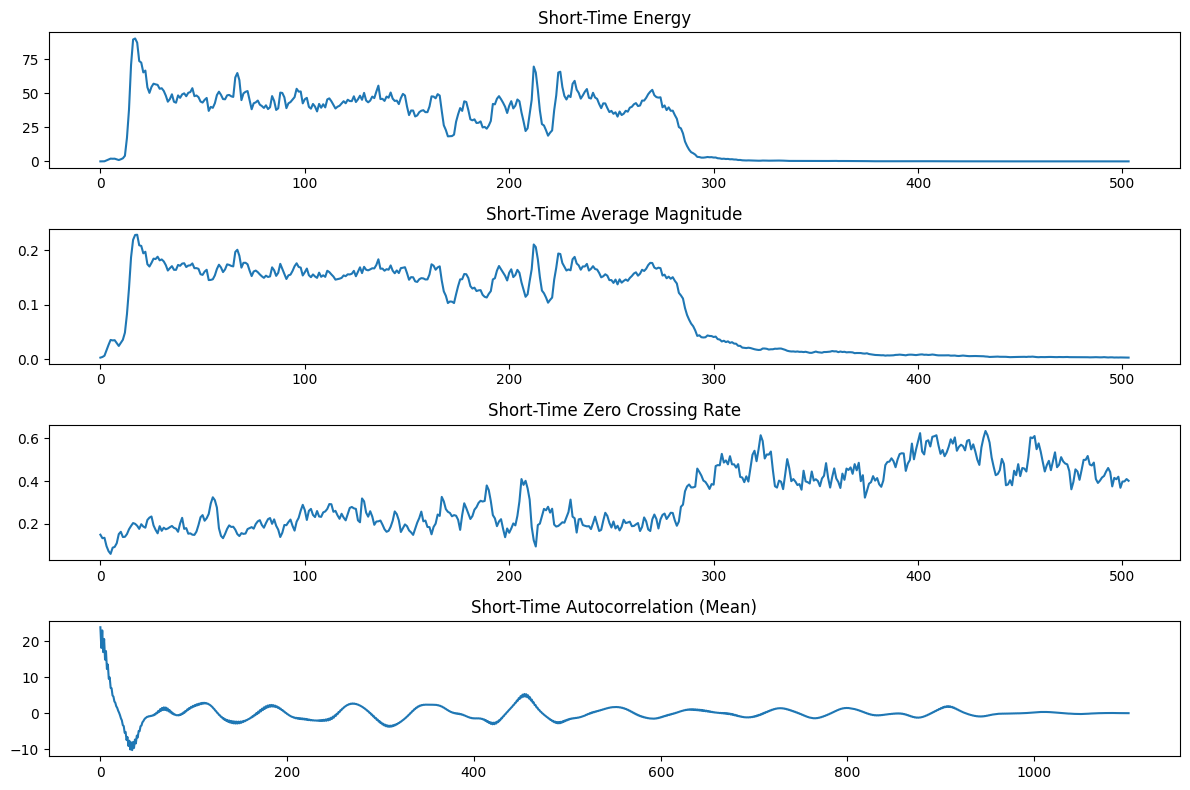

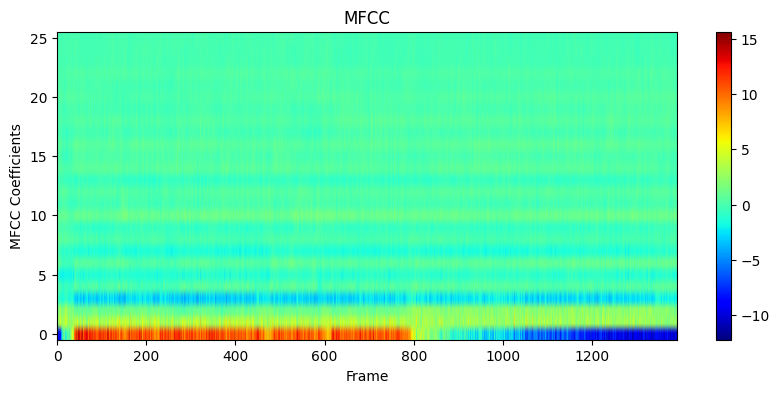

In [11]:
file_path = 'input_file.wav'
samples, sample_rate = read_mav_file(file_path)

# 设置窗口大小和跳跃步长
window_size = int(0.025 * sample_rate)
hop_size = int(0.01 * sample_rate)

# 归一化信号
samples = samples / np.max(np.abs(samples))

# 提取特征
energy = short_time_energy(samples, window_size, hop_size)
magnitude = short_time_average_magnitude(samples, window_size, hop_size)
zcr = short_time_zero_crossing_rate(samples, window_size, hop_size)
autocorr = short_time_autocorrelation(samples, window_size, hop_size)

# 可视化短时特征
plot_features(energy, magnitude, zcr, autocorr)

mfcc = compute_mfcc(samples, sample_rate)
plot_mfcc(mfcc)